#### SEGUNDA PARTE
#### CONSISTE EN LA GENERACIÓN DEL MODELO. 

Realizada por Carlos Mendoza R. 

*Se separó con el fin de no extender demasiado el documento y separar el análisis exploratiorio de las variables de la creación del modelo* 

*Entendiendo que el primer archivo puede servir de input a este para entregar las variables seleccionadas para el modelo y aquí obtener el mejor modelo para la predicción de exoplanetas.

In [11]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
#import plotly.express as px

import scipy.stats as ss
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
accuracy_score,recall_score,precision_score,f1_score)

from xgboost import XGBClassifier
from scipy.stats import uniform, randint

#plt.style.use('seaborn-bright')

- Las variables seleccionadas del proceso anterior son las siguientes:

In [5]:
features_variables = ['koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec',
'koi_impact_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad_err2',
'koi_period','koi_time0bk','koi_impact','koi_impact_err1','koi_impact_err2',
'koi_steff','koi_steff_err1','koi_steff_err2','koi_model_snr','koi_srad','koi_duration'
]
model_variables = ['koi_disposition','koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec',
'koi_impact_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad_err2',
'koi_period','koi_time0bk','koi_impact','koi_impact_err1','koi_impact_err2',
'koi_steff','koi_steff_err1','koi_steff_err2','koi_model_snr','koi_srad','koi_duration'
]
len(features_variables)

19

En el siguiente código se muestra:
1. Importación de la data.
2. Creación de la variable objetivo.
3. Filtro de variables elegidas para el modelo


In [6]:
#Lectura de la data
data = pd.read_csv('exoplanetas.csv', sep = ',')
df = data.copy()
df.pop('Unnamed: 0')

#Creación de variable objetivo como binaria. 
model_data = df.copy()
model_data.koi_disposition[model_data.koi_disposition == 'FALSE POSITIVE'] = 0
model_data.koi_disposition[model_data.koi_disposition == 'CANDIDATE'] = 0
model_data.koi_disposition[model_data.koi_disposition == 'CONFIRMED'] = 1
model_data = model_data[model_variables]

# Mezclar la data para darle aleatoriedad a esta y quitar cualquier sesgo de imputación. 
np.random.seed(4)
model_data = shuffle(model_data)
model_data = model_data.reset_index()
model_data.pop('index')
model_data.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_impact_err2,koi_depth_err1,koi_depth_err2,koi_prad_err2,koi_period,koi_time0bk,koi_impact,koi_impact_err1,koi_impact_err2,koi_steff,koi_steff_err1,koi_steff_err2,koi_model_snr,koi_srad,koi_duration
0,1,0,0,0,0,-0.2270,23.5,-23.5,-0.06,5.774403,132.96695,0.4250,0.5150,-0.2270,3808,76,-84,11.8,0.508,1.76800
1,0,0,1,0,0,-0.0050,153.0,-153.0,-6.39,3.564614,131.86235,0.9890,0.0340,-0.0050,5891,177,-195,728.8,0.892,3.44204
2,1,0,0,0,0,-0.1600,18.5,-18.5,-0.08,2.295035,132.69329,0.1600,0.2910,-0.1600,5637,101,-112,11.6,0.909,1.65400
3,0,0,0,0,0,-0.2514,14.6,-14.6,-0.13,0.783258,131.74358,0.2514,0.2138,-0.2514,5067,195,-155,28.5,0.715,2.29260
4,0,0,0,0,0,-0.2050,8.0,-8.0,-0.82,21.236002,149.88083,0.2050,0.2620,-0.2050,6035,132,-120,15.7,2.559,4.01900


En la siguiente sección se realiza la división de la data en 2 dataset:
1. Training Data Set. Es un 80%. 
2. Testing Data Set. Es un 20%. 

In [7]:
# Definición de cortes.
train_cut = int(len(model_data)*0.8)
test_cut = int(len(model_data))-train_cut

train_features = model_data.iloc[:train_cut,1:].values
test_features = model_data.iloc[train_cut:,1:].values

train_target = model_data.iloc[:train_cut,0].values.astype('int')
test_target =model_data.iloc[train_cut:,0].values.astype('int')

scaler = MinMaxScaler()
scaler.fit(train_features)


MinMaxScaler()

### Dentro de las metricas a utilizar para optimizar estos modelos tenemos: 
1. Accuracy: (TP+TN)/(TP+TN+FP+FN): Nos ayuda a encontrar la mejor predicción consideranto tanto los True Negatives y True Positives.

2. Precision: (TP)/(TP+FP). Nos da una medida de calidad del modelo al obtener al saber el porcentaje de planetas que predecimos correctamente sobre el total que predecimos como planetas. 

3. Recall: (TP)/(FN+TP). Nos entrega el porcentaje de aciertos entre los valores positivos (los que si son planetas) reales. 

4. F1 score. Combinación de Recall y Precision. 

#### Usualmente usuaria recall para aumentar la cantidad de predicciones TP que podriamos acertar. Sin embargo, utilizaré la Precisión como medida para los modelos para ir disminuyendo la cantidad de Falsos positivos que podamos predecir(Existian hartos 50% jaja en la base de datos) y así asegurarnos si es que vamos a dar por confirmado un planeta este de verdad sea uno con la mayor precision posible.

De todas manera f1 y recall serian opciones validas a utilizar. Habría que confirmar bien que es lo que la NASA esta buscando o preferia priorizar. Accuracy no iria al caso dado la naturaleza del problema no es interesante saber cuales no son planetas no confirmados. 

In [8]:
#Creacción del modelo Logistic regresion. (Como primer modelo)
model = LogisticRegression()
model.fit(X = scaler.transform(train_features), y = train_target)

test_pred = model.predict(scaler.transform(test_features))


def f1_scr(precision,recall):
    """ Función para calcular el F1 score """
    return 2*(precision*recall)/(precision + recall)

def get_metrics(y_target, y_pred):
    """ Función para calcular todas las metricas e imprimirlas. 
    Creada solo para ahorrar tiempo dsp"""
    recall = recall_score(y_target,y_pred)
    presicion = precision_score(y_target,y_pred)
    f1 = f1_scr(presicion,recall)
    accuracy = accuracy_score(y_target,y_pred)

    print("Recall: {}%, Presicion: {}%, F1 score: {}%, Accuracy: {}%".format(
        round(recall,3)*100,
        round(presicion,3)*100,
        round(f1,3)*100,
        round(accuracy,3)*100)
        )
    return recall,presicion,f1,accuracy 

get_metrics(test_target,test_pred)

Recall: 67.60000000000001%, Presicion: 62.8%, F1 score: 65.2%, Accuracy: 82.39999999999999%


(0.6764705882352942, 0.6284153005464481, 0.651558073654391, 0.8241601143674053)

Ahora vamos a optimizar hyperparametros con la técnica de Grid Research Cross Validation.
La idea es encontrar la mejor configuración de hyperparemetros que maximice la métrica recall. 


In [6]:
metrics = ['recall','f1','precision'] #se definen las métricas a considerar. 
for metric in metrics: 
    model_i = LogisticRegression()   #definimos el modelo
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l1','l2','elasticity']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    # define grid search
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model_i, param_grid=grid, n_jobs=-1, cv=cv, scoring=metric,error_score=0)
    grid_result = grid_search.fit(scaler.transform(train_features), train_target)
    # summarize results
    print(f" The Best model using {metric} metric. Value: {grid_result.best_score_} using {grid_result.best_params_}")

#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

 The Best model using recall metric. Value: 0.7317351598173516 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
 The Best model using f1 metric. Value: 0.6947316255106929 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
 The Best model using precision metric. Value: 0.6706587057980093 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Ahora vamos a evaluar el modelo optimizado con los parametros de mejor rendimiento.
Se observa que el recall es de un 72.1% con un aumento de 4.5pp.

In [7]:
#Ajustar el modelo.
best_model = LogisticRegression(C = 0.1, solver = 'liblinear', penalty = 'l2')
best_model.fit(scaler.transform(train_features),train_target)

#Obtener predicciones.
best_test_pred = best_model.predict(scaler.transform(test_features))

#Cálculo de métricas
get_metrics(test_target,best_test_pred)



Recall: 62.4%, Presicion: 66.7%, F1 score: 64.4%, Accuracy: 83.3%


(0.6235294117647059,
 0.6666666666666666,
 0.6443768996960486,
 0.8327376697641172)

Para obtener la matriz de confusión vamos a utilizar las librerias de sklearn.metrics

Cantidad de valores testeado: 1399


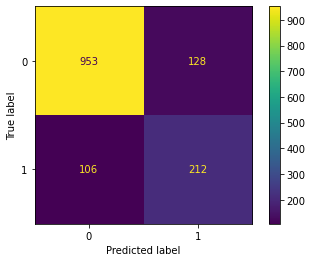

In [18]:
cm = confusion_matrix(best_test_pred,test_target)
print("Cantidad de valores testeado: {}".format(sum(sum(cm))))

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()


Si nuestro modelo nos indica que un candidato es confirmado como planeta, ¿Qué tan seguros podemos estar de qué este sea efectivamente un planeta?
- R: Me voy a tomar de la métrica precisión que nos índica de los planetas que predecimos cuantos efectivamente lo son.
- La métrica recall nos entrega el porcentaje de los planetas confirmados sobre el total de planetas que realmente lo son. 


Ahora vamos a probar XGBOOST que generalmente tiene mejor desempeño que varios modelos de ML.

In [9]:


xgb_model = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric = "auc")
xgb_model.fit(scaler.transform(train_features),train_target)

xgb_predict = xgb_model.predict(scaler.transform(test_features))

get_metrics(test_target,xgb_predict)



Recall: 85.0%, Presicion: 78.10000000000001%, F1 score: 81.39999999999999%, Accuracy: 90.60000000000001%


(0.85, 0.7810810810810811, 0.8140845070422537, 0.9056468906361687)

In [158]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [163]:
#Definición de parametros a iterar de manera random 
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}
#Métricas a optimizar
metrics = ['precision','recall','f1']

#Proceso que  optimiza a través de RANDOMIZED SEARCH CROSS VALIDATION
for metric in metrics: 
    xgb_model_opt = XGBClassifier()
    search = RandomizedSearchCV(xgb_model_opt, param_distributions=params, random_state=42, 
                                n_iter=200, cv=3, verbose=1, n_jobs=1, 
                                return_train_score=True,scoring=metric)

    random_result = search.fit(scaler.transform(train_features), train_target)
    print(f" The Best model using {metric} metric. Value: {random_result.best_score_} using {random_result.best_params_}")
    report_best_scores(search.cv_results_, 1)


Fitting 3 folds for each of 200 candidates, totalling 600 fits
 The Best model using precision metric. Value: 0.8074116526441193 using {'colsample_bytree': 0.794306794322898, 'gamma': 0.2542853455823514, 'learning_rate': 0.3022699421778279, 'max_depth': 4, 'n_estimators': 138, 'subsample': 0.7641531692142519}
Model with rank: 1
Mean validation score: 0.807 (std: 0.023)
Parameters: {'colsample_bytree': 0.794306794322898, 'gamma': 0.2542853455823514, 'learning_rate': 0.3022699421778279, 'max_depth': 4, 'n_estimators': 138, 'subsample': 0.7641531692142519}

Fitting 3 folds for each of 200 candidates, totalling 600 fits
 The Best model using recall metric. Value: 0.8520588806922369 using {'colsample_bytree': 0.8958238323555624, 'gamma': 0.11909139052336326, 'learning_rate': 0.05983241782780355, 'max_depth': 5, 'n_estimators': 123, 'subsample': 0.8889067727422637}
Model with rank: 1
Mean validation score: 0.852 (std: 0.005)
Parameters: {'colsample_bytree': 0.8958238323555624, 'gamma': 0.119

In [14]:
#Codear modelo optimizado!! 
best_xgb_model = XGBClassifier(colsample_bytree= 0.794306794322898, 
                                gamma =  0.2542853455823514, 
                                learning_rate = 0.3022699421778279,
                                max_depth= 4, 
                                n_estimators= 138,
                                subsample = 0.7641531692142519)

#Ajustar el modelo
best_xgb_model.fit(scaler.transform(train_features),train_target)

#Predecir los valores
best_xgb_pred = best_xgb_model.predict(scaler.transform(test_features))

#Obtener las métricas
get_metrics(test_target,best_xgb_pred)



Recall: 83.8%, Presicion: 78.9%, F1 score: 81.3%, Accuracy: 90.60000000000001%


(0.8382352941176471, 0.7894736842105263, 0.8131241084165478, 0.906361686919228)

Cantidad de valores testeado: 1399


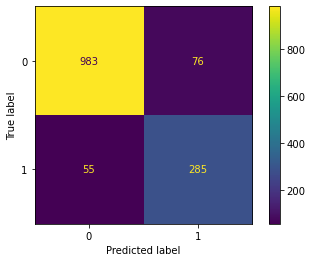

In [15]:
xgb_cm = confusion_matrix(test_target,best_xgb_pred)
print("Cantidad de valores testeado: {}".format(sum(sum(xgb_cm))))

xgb_cm_display = ConfusionMatrixDisplay(confusion_matrix=xgb_cm)
xgb_cm_display.plot()

Si nuestro modelo nos indica que un candidato es confirmado como planeta, ¿Qu ́e tan seguros podemos estar de que  ́este sea efectivamente un planeta? Comente

- Utilizare la metrica f1 score como base para responder esta pregunta ya que nos entrga un valor 'medio' entre la precision y recall. Por lo que estariamos hablando para el modelo de XGBOOST el cual tiene un mejor desempeño en todas las métricas. Podriamos estar seguro en un 82% aproximadamente. Sobre un 80% considerando recall y precision.

Ahora se obtine el grafico de 'feature importance' con el fin de entender a que variables es más sensible el modelo y poder hacer recomentadicones cualitativas.

<BarContainer object of 19 artists>

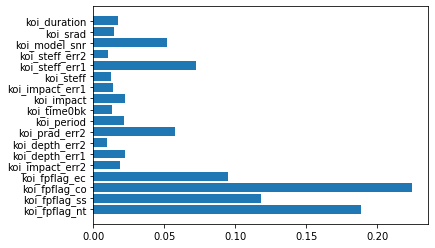

In [22]:

plt.barh(features_variables,best_xgb_model.feature_importances_)